In [1]:
import rootutils
rootutils.setup_root(".", indicator=".project-root", pythonpath=True, cwd=True)

PosixPath('/home/dgcnz/development/thesis/PART')

In [2]:
cwd = rootutils.find_root()
print(type(cwd))

<class 'pathlib.PosixPath'>


In [3]:
import pytest
from PIL import Image
import torchvision.transforms.v2.functional as TTFv2
import hydra
from omegaconf import OmegaConf
import torch
from src.models.part_vit_module import PARTViTModule
from src.data.hf_datamodule import HFDataModule
import lightning as L
import math
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib 
# jupyter matplotlib
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
from copy import deepcopy
from src.callbacks import HeadHookLogger


In [4]:
with hydra.initialize(version_base=None, config_path="../../configs"):
    cfg = hydra.compose(
        config_name="train.yaml",
        overrides=[
            "experiment=hs_part_im1k_pairdiff_mlp",
            "model/criterion_fn=l1",
            "model.sample_mode=offgrid",
            "data.num_workers=0",
        ],
    )
    OmegaConf.register_new_resolver("eval", eval)

In [5]:
module: PARTViTModule = hydra.utils.instantiate(cfg.model).eval()
datamodule: HFDataModule = hydra.utils.instantiate(cfg.data)
datamodule.setup("fit")
train_dataloader = datamodule.train_dataloader()
train_iter = iter(train_dataloader)
batch = next(train_iter)


/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'train_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['train_transform'])`.
/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'test_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['test_transform'])`.


Loading dataset shards:   0%|          | 0/257 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/25 [00:00<?, ?it/s]

/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3611.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


default Loss: 0.4771
kaiming_uniform:4.5 Loss: 0.3870
kaiming_uniform:10 Loss: 0.3307
normal Loss: 0.4052
Ideal Loss: tensor(0.3083)


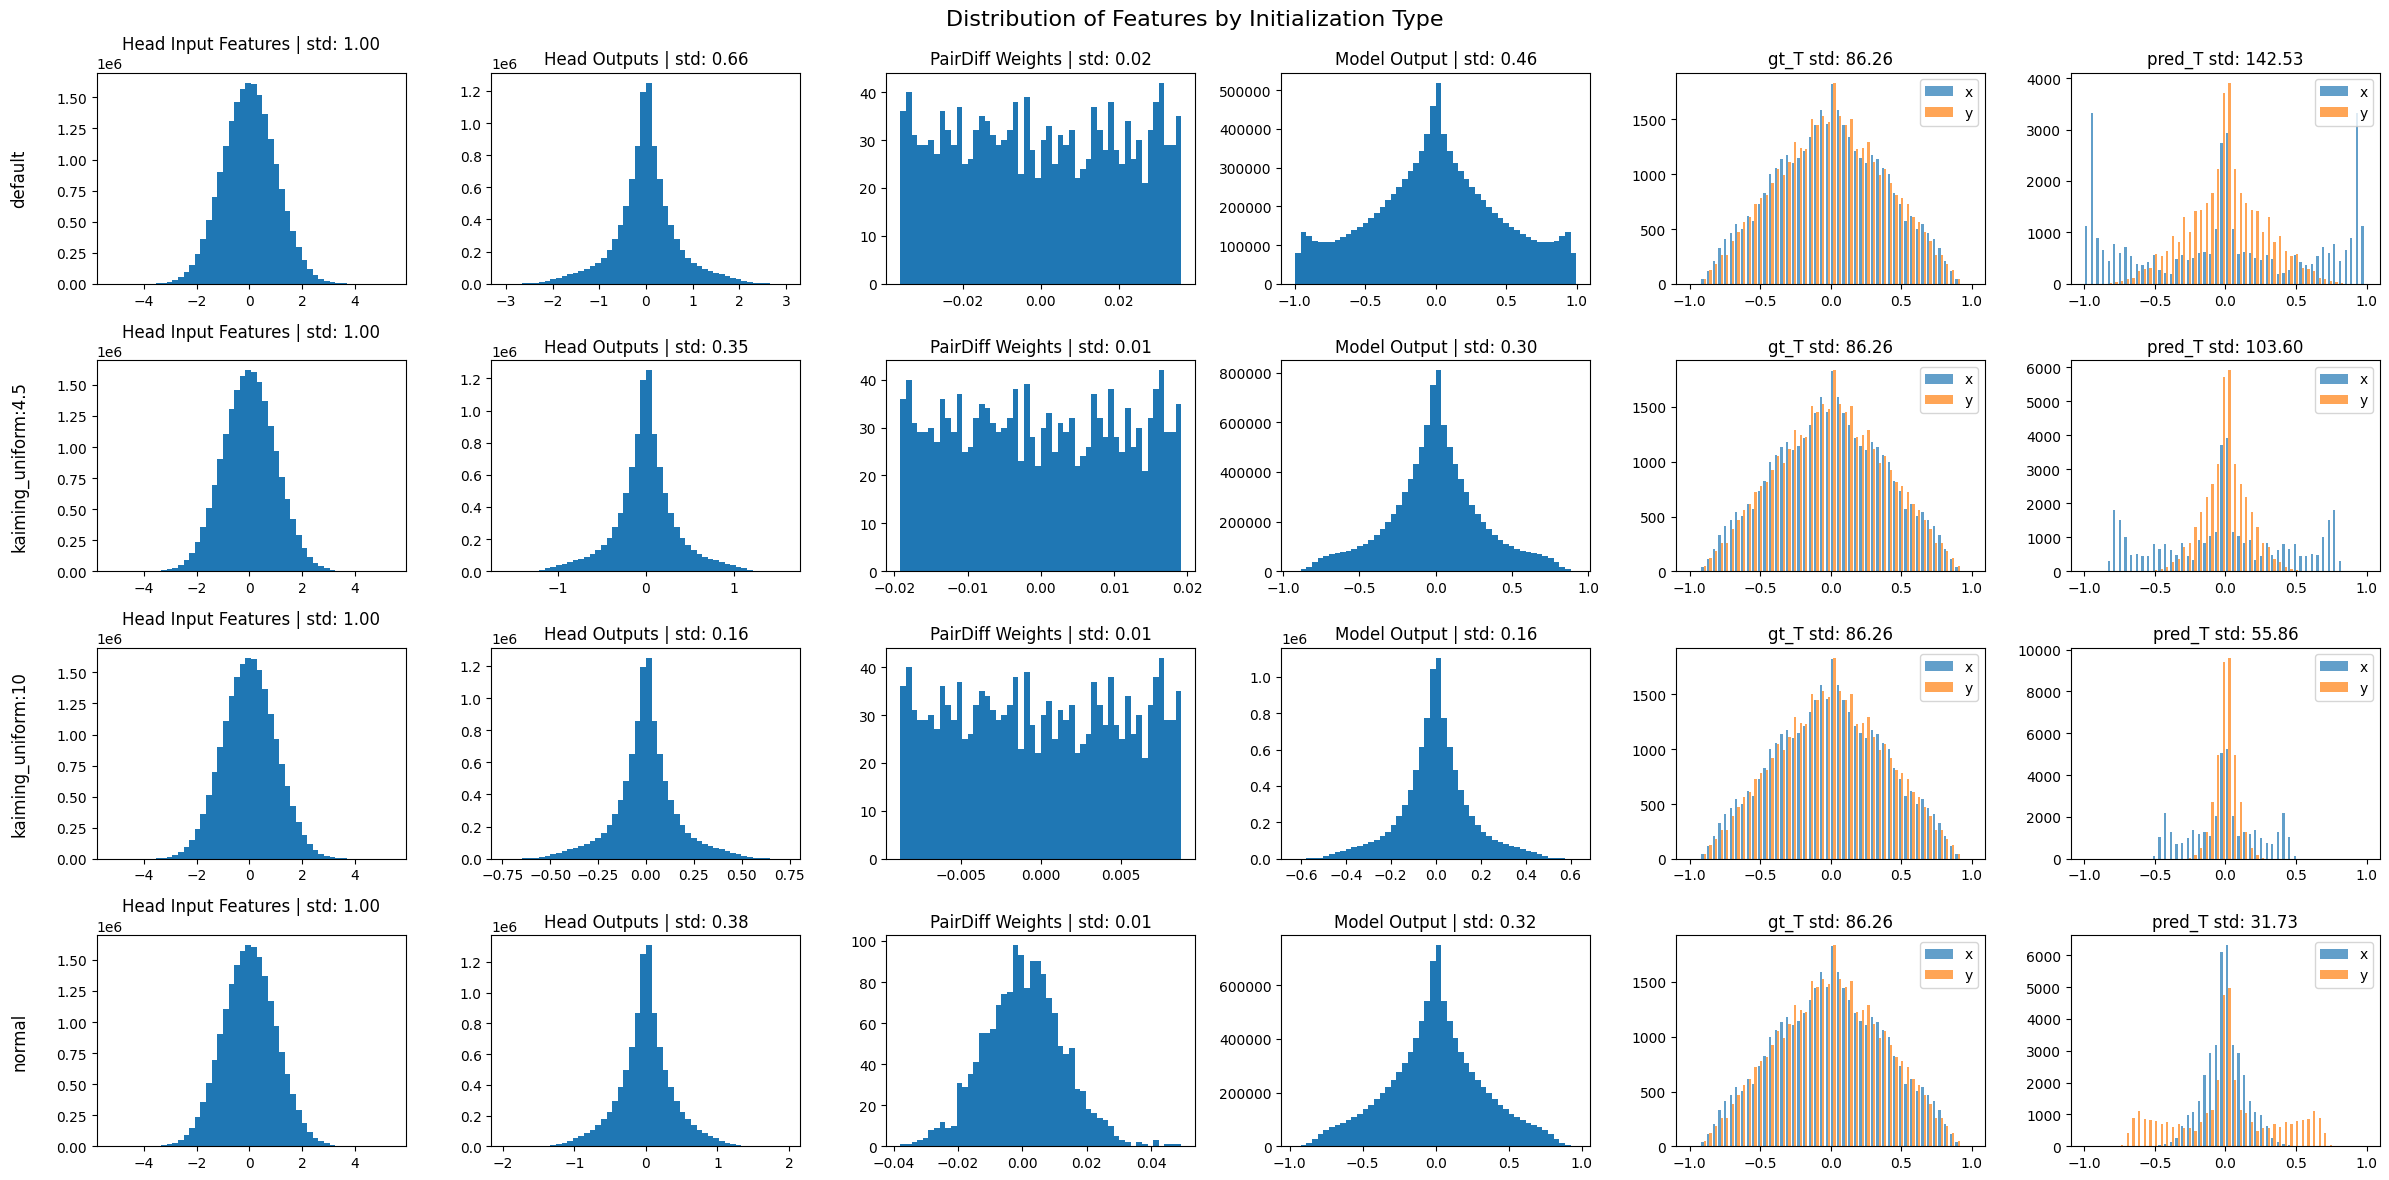

In [6]:

def hook_and_run(module, batch, seed=0):
    callback = HeadHookLogger()
    callback._attach_hooks(module) 

    torch.manual_seed(seed)
    with torch.no_grad(): 
        out = module.model_step(batch)
    
    # Remove hooks
    callback._detach_hooks()
    return out, callback


def _compute_ideal_loss(gt_T):
    median = gt_T.median().item()
    median_T = torch.full_like(gt_T, median)
    loss = torch.nn.functional.l1_loss(gt_T, median_T)
    return loss


def run_and_plot(init_fn, module, axes):
    torch.manual_seed(0)
    init_fn(module.net.head.proj)

    # record memory history torch
    out, callback = hook_and_run(module, batch)
    callback._plot(axes[:4], module, _hist_kwargs=[])

    # # Separate x and y components for selected tensors
    gt_T = (out["gt_T"] / module.net.logit_scale).detach().cpu()
    pred_T = (out["pred_T"] / module.net.logit_scale).detach().cpu()

    # # Define the data mapping
    data = {
        'gt_T': (*gt_T[0].unbind(dim=-1), -1, 1),
        'pred_T': (*pred_T[0].unbind(dim=-1), -1, 1),
    }

    for ax, (name, (y_data, x_data, mn, mx)) in zip(axes[4:], data.items()):
        ax.hist([x_data.flatten(), y_data.flatten()], bins=50, 
                      label=['x', 'y'], alpha=0.7, range=(mn, mx) if mn is not None else None)
        ax.legend()
        std = torch.std(x_data * module.net.logit_scale)
        ax.set_title(f"{name} std: {std:.2f}")

    return out["loss"], _compute_ideal_loss(gt_T)

inits = {
    "default": lambda m: m.reset_parameters(),
    "kaiming_uniform:4.5": lambda m: torch.nn.init.kaiming_uniform_(m.weight, a=4.5),
    "kaiming_uniform:10": lambda m: torch.nn.init.kaiming_uniform_(m.weight, a=10),
    "normal": lambda m: torch.nn.init.normal_(m.weight, 0, 1.0 / (3 * math.sqrt(m.weight.shape[1]))),
}

# Create figure and axes
fig, axes = plt.subplots(len(inits), 6, figsize=(24, 12))

# Add a main title
fig.suptitle('Distribution of Features by Initialization Type', fontsize=16)

# Add column labels
for ax, row in zip(axes[:, 0], inits.keys()):
    ax.set_ylabel(row, fontsize=12, rotation=90, labelpad=20)

# Run the experiment and plot results for each initialization type
for (init_name, init_fn), ax in zip(inits.items(), axes):
    module_copy = deepcopy(module)
    loss, ideal_loss = run_and_plot(init_fn, module_copy, ax)
    print(f"{init_name} Loss: {loss:.4f}")

print("Ideal Loss:", ideal_loss)

plt.tight_layout()
plt.show()
